2025-05-29 13:35:38.793146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748525739.334868      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748525739.469930      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 34793 non-validated image filenames belonging to 8 classes.
Found 6141 non-validated image filenames belonging to 8 classes.


I0000 00:00:1748525786.493707      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748525786.494334      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1748525793.886003      97 service.cc:148] XLA service 0x7a4b3c007880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748525793.887505      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748525793.887524      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748525794.551295      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1088 ━━━━━━━━━━━━━━━━━━━━ 1:21 75ms/step - accuracy: 0.1875 - loss: 12.8978  

I0000 00:00:1748525801.189453      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 222s 194ms/step - accuracy: 0.2455 - loss: 9.4734 - val_accuracy: 0.3356 - val_loss: 4.9123 - learning_rate: 1.0000e-04
Epoch 2/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 129s 119ms/step - accuracy: 0.3465 - loss: 4.1790 - val_accuracy: 0.4315 - val_loss: 2.9625 - learning_rate: 1.0000e-04
Epoch 3/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 128s 118ms/step - accuracy: 0.3964 - loss: 2.8400 - val_accuracy: 0.4498 - val_loss: 2.2292 - learning_rate: 1.0000e-04
Epoch 4/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 126s 116ms/step - accuracy: 0.4281 - loss: 2.2059 - val_accuracy: 0.4766 - val_loss: 1.8276 - learning_rate: 1.0000e-04
Epoch 5/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 126s 115ms/step - accuracy: 0.4490 - loss: 1.8559 - val_accuracy: 0.4752 - val_loss: 1.6594 - learning_rate: 1.0000e-04
Epoch 6/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 125s 115ms/step - accuracy: 0.4655 - loss: 1.6676 - val_accuracy: 0.5105 - val_loss: 1.4853 - learning_rate: 1.0000e-04
Epoch 7/50
1088/1088 ━━━━━━━━━━━━━━━━━━

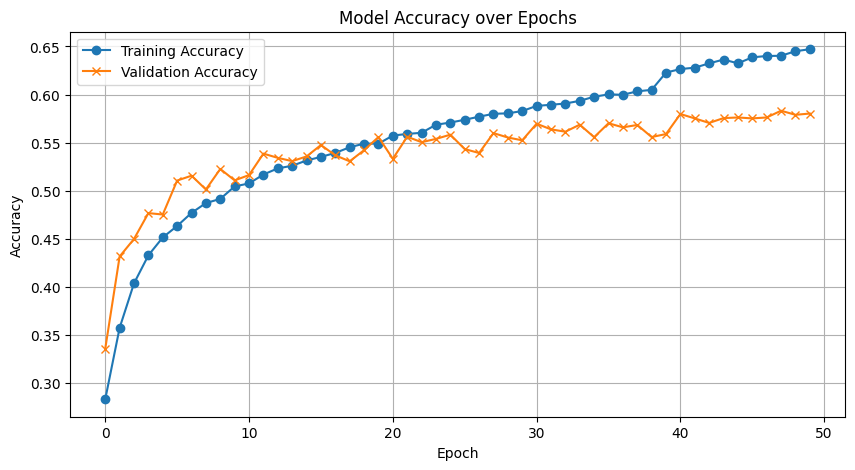

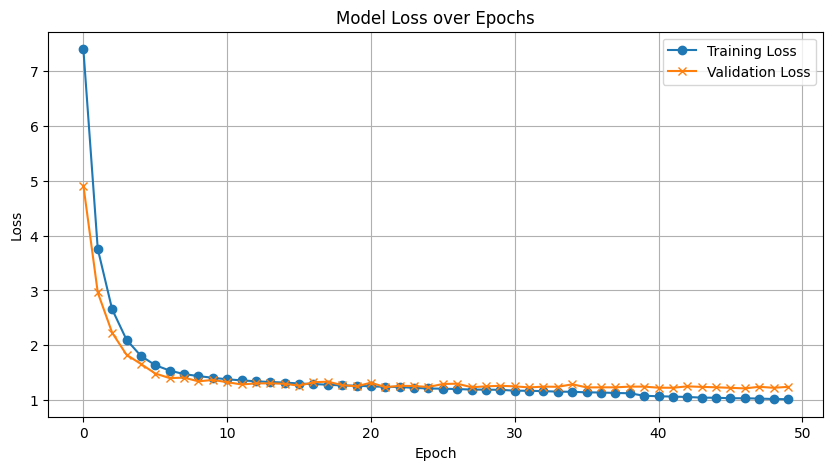

192/192 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step


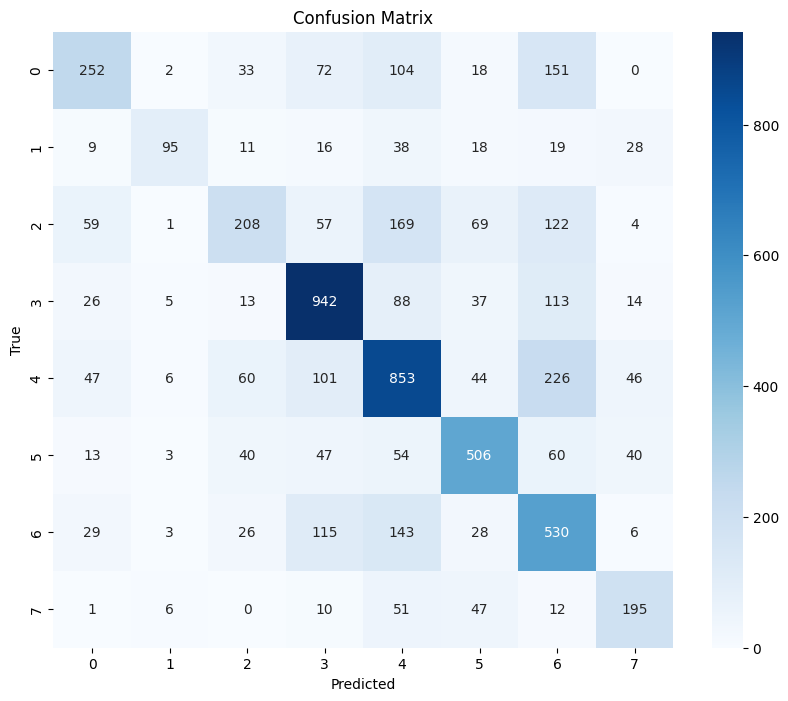

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.40      0.47       632
           1       0.79      0.41      0.54       234
           2       0.53      0.30      0.39       689
           3       0.69      0.76      0.73      1238
           4       0.57      0.62      0.59      1383
           5       0.66      0.66      0.66       763
           6       0.43      0.60      0.50       880
           7       0.59      0.61      0.60       322

    accuracy                           0.58      6141
   macro avg       0.60      0.54      0.56      6141
weighted avg       0.59      0.58      0.58      6141



In [1]:
import os
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import json

# تحميل بيانات FER2013
fer_path = '/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv'
df_fer = pd.read_csv(fer_path)

# تحويل البكسلات إلى صور
def pixels_to_image(row, save_dir="/kaggle/working/fer_images"):
    os.makedirs(save_dir, exist_ok=True)
    img_array = np.array(row["pixels"].split(), dtype=np.uint8).reshape(48, 48)
    img_path = os.path.join(save_dir, f"fer_{row.name}.jpg")
    Image.fromarray(img_array).convert("RGB").save(img_path)
    return img_path

df_fer["image_path"] = df_fer.apply(pixels_to_image, axis=1)
df_fer = df_fer[["image_path", "emotion"]].rename(columns={"emotion": "label"})
df_fer["dataset"] = "FER2013"

# تحميل بيانات RAF-DB
raf_train_path = "/kaggle/input/raf-db-dataset/DATASET/train"
raf_train_imgs_path = []
raf_train_labels = []

for folder in os.listdir(raf_train_path):
    folder_path = os.path.join(raf_train_path, folder)
    if os.path.isdir(folder_path):
        image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))
        raf_train_imgs_path.extend(image_paths)
        raf_train_labels.extend([folder] * len(image_paths))

df_raf = pd.DataFrame({"image_path": raf_train_imgs_path, "label": raf_train_labels})
df_raf["dataset"] = "RAF-DB"

# دمج البيانات
df_combined = pd.concat([df_fer, df_raf], ignore_index=True)
df_combined["label"] = df_combined["label"].astype(int)

# تقسيم البيانات
train_df, test_df = train_test_split(df_combined, test_size=0.15, stratify=df_combined["label"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df["label"], random_state=42)

# تحويل التصنيفات إلى نصوص لتتناسب مع ImageDataGenerator
train_df["label"] = train_df["label"].astype(str)
val_df["label"] = val_df["label"].astype(str)

# إعداد الصور
target_img_size = (96, 96)

# Augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=25, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    brightness_range=[0.8, 1.2], fill_mode='reflect'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="image_path", y_col="label", target_size=target_img_size,
    batch_size=32, class_mode="categorical", shuffle=True, validate_filenames=False
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col="image_path", y_col="label", target_size=target_img_size,
    batch_size=32, class_mode="categorical", shuffle=False, validate_filenames=False
)


with open("/kaggle/working/class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)

# بناء النموذج
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
for layer in base_model.layers[:19]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.3)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# الكولباكات
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6),
    ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# تدريب النموذج
history = model.fit(
    train_generator, validation_data=val_generator,
    epochs=50, callbacks=callbacks
)

#حفظ النموذج 
model.save('/kaggle/working/final_model.h5')

# رسم الأداء
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_generator.reset()
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# أسماء الفئات
class_labels = list(val_generator.class_indices.keys())

# ✅ مصفوفة الالتباس (Confusion Matrix)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ✅ تقرير التصنيف (Classification Report)
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(report)

# ✅ حفظ التقرير النصي في ملف
with open("/kaggle/working/classification_report.txt", "w") as f:
    f.write(report)

In [44]:
!pip install streamlit
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2025-05-28 17:27:53--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 13.248.244.96, 35.71.179.82, 75.2.60.68, ...
Connecting to bin.equinox.io (bin.equinox.io)|13.248.244.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.28M  18.7MB/s    in 0.7s    

2025-05-28 17:27:54 (18.7 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename:   Stopping...
^C


In [ ]:
!./ngrok authtoken 2xSGAfzyIj2Pvua5gfnstky6yZ6_4TQp65dby9tRWQqPHFn65


In [47]:
!pip install streamlit
!pip install pyngrok


In [48]:
%%writefile app.py
import streamlit as st
import numpy as np
import cv2
import sqlite3
import os
import shutil
from datetime import datetime
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array


input_db_path = "/kaggle/input/databases/emotions_updated.db"  # تأكد من اسم المجلد
working_db_path = "/kaggle/working/emotions.db"

if not os.path.exists(working_db_path):
    shutil.copy(input_db_path, working_db_path)


conn = sqlite3.connect(working_db_path, check_same_thread=False)
cursor = conn.cursor()

def create_table():
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS EmotionResults (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            image_data BLOB NOT NULL,
            predicted_emotion TEXT NOT NULL,
            confidence REAL,
            time TEXT
        );
    """)
    conn.commit()

create_table()

def insert_prediction(image_data, predicted_emotion, confidence, time):
    cursor.execute("""
        INSERT INTO EmotionResults (image_data, predicted_emotion, confidence, time)
        VALUES (?, ?, ?, ?)
    """, (image_data, predicted_emotion, confidence, time))
    conn.commit()

# إعداد واجهة Streamlit
st.set_page_config(
    page_title="Emotion Detector 🎭",
    page_icon="🧠",
    layout="centered",
    initial_sidebar_state="auto"
)

st.markdown("""
    <h1 style='text-align: center; color: #4B8BBE;'>Emotion Recognition System 🎭</h1>
    <h4 style='text-align: center; color: gray;'>Detect emotions from facial expressions using deep learning</h4>
    <hr style='border: 1px solid #f0f0f0;'>
""", unsafe_allow_html=True)

# تحميل النموذج
@st.cache_resource
def load_image_model():
    model_path = "/kaggle/input/best-model/manual_best_model.h5"
    return load_model(model_path)

model = load_image_model()

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emojis = {
    'Angry': '😠', 'Disgust': '🤢', 'Fear': '😨', 'Happy': '😄',
    'Sad': '😢', 'Surprise': '😲', 'Neutral': '😐'
}

# رفع صورة
st.markdown("### 🖼️ Upload a Face Image")
uploaded_image = st.file_uploader("Upload an image (jpg, jpeg, png)", type=["jpg", "jpeg", "png"])

# توقع المشاعر
if uploaded_image is not None:
    if st.button("🔍 Predict Emotion"):
        img_bytes = uploaded_image.read()
        img_array = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
        img = cv2.resize(img_array, (96, 96))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display_img = img.copy()
        img = img.astype("float32") / 255.0
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)

        preds = model.predict(img, verbose=0)
        confidence = float(np.max(preds))
        label = labels[np.argmax(preds)]

        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        insert_prediction(img_bytes, label, confidence, current_time)

        # عرض النتيجة
        st.image(display_img, caption="Analyzed Image", use_column_width=True)
        st.markdown("---")
        st.markdown(f"### 🎯 Prediction: *{label}* {emojis[label]}")
        st.progress(confidence)
        st.markdown(f"*Confidence:* {confidence * 100:.2f}%")
        st.markdown("---")
else:
    st.info("⬆️ Please upload an image to start.")

# عرض السجل
if st.checkbox("📊 Show prediction history"):
    cursor.execute("SELECT image_data, predicted_emotion, confidence, time FROM EmotionResults ORDER BY id DESC")
    results = cursor.fetchall()
    for row in results:
        st.image(row[0], caption="Uploaded Image", width=200)
        st.markdown(f"😃 *{row[1]}* | 📈 {row[2]*100:.2f}% | 🕒 {row[3]}")
        st.markdown("---")

# نسخ قاعدة البيانات المحدثة للتحميل
shutil.copy(working_db_path, "/kaggle/working/emotions_updated.db")


Overwriting app.py


In [50]:
!pip install pyngrok


In [51]:
!ngrok authtoken 2xSGAfzyIj2Pvua5gfnstky6yZ6_4TQp65dby9tRWQqPHFn65


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("")


In [57]:
!pip install streamlit


In [30]:
pip install pyngrok


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pyngrok import ngrok
import subprocess
import time

# تعيين رقم البورت
port = 8501

# تشغيل Streamlit في subprocess
process = subprocess.Popen(['streamlit', 'run', 'app.py', '--server.port', str(port), '--server.headless', 'true'])


time.sleep(5)

# إنشاء نفق ngrok على نفس البورت
public_url = ngrok.connect(port).public_url

print(f"Streamlit app running at: {public_url}")





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.19.2.2:8501
  External URL: http://34.46.170.55:8501

Streamlit app running at: https://d557-34-46-170-55.ngrok-free.app


2025-05-28 17:33:03.078426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748453583.106776     498 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748453583.115507     498 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1748453587.765032     498 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748453587.765798     498 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

In [3]:
!pip install streamlit pyngrok tensorflow opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 65.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requ